In [47]:
import ipywidgets as widgets
import umap.umap_ as umap
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import os
from ipywidgets import interact
from matplotlib.widgets import Slider
from umap import UMAP
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
def plot_pca_variance(n_components,cumulative_variance_ratio_all):

    cumulative_variance_ratio = cumulative_variance_ratio_all[:n_components]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance_ratio, marker='o')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA: Explained Variance Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

# Part 2: Supervised Learning
## 1. Data Loading

In [8]:
data = pd.read_csv('electrophysiology_data.csv', index_col=0)
data

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,7.766982,0.242468,2.451400,1.736200,-0.089253,-0.017794,-0.036484,0.312714
1,17.940081,0.261169,0.729700,2.098900,-0.189602,-0.020596,-0.054364,0.381867
2,3.595100,0.174408,0.900318,-0.089208,-0.036845,-0.002994,0.001233,0.105970
3,1.673900,0.162970,0.914393,-0.365906,-0.025686,-0.000676,0.008585,0.069576
4,8.588500,0.204138,0.863736,0.629957,-0.065850,-0.009018,-0.017877,0.200561
...,...,...,...,...,...,...,...,...
57,11.840713,0.218294,1.262940,1.679856,-0.073851,-0.011318,-0.036244,0.241595
58,11.188700,0.230496,1.168000,1.312942,-0.096420,0.002325,-0.211021,0.619361
59,11.289800,0.236296,0.542700,0.626257,-0.091402,-0.025925,-0.036946,0.618007
60,4.743000,0.215044,1.359354,0.183553,-0.083273,-0.016779,-0.020993,0.291977


# 2. Dimensionality Reduction



In [21]:
# Preprocess the data
X = data.values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2a. t-SNE

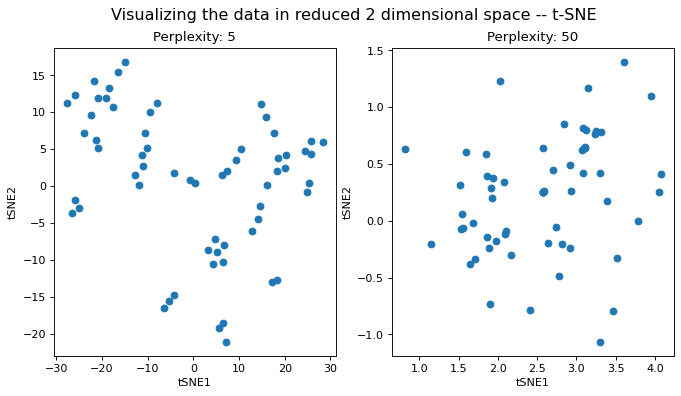

In [46]:
perplexity = [5, 50]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
fig.suptitle("Visualizing the data in reduced 2 dimensional space -- t-SNE", size='x-large')

for i, perplexity in enumerate(perplexity):
    tsne =  TSNE(n_components=2, random_state=None, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_scaled) 

    ax = axes[i]

    # plot
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1])
    ax.set_xlabel("tSNE1")
    ax.set_ylabel("tSNE2")
    ax.set_title("Perplexity: " + str(perplexity))

## 2b. UMAP

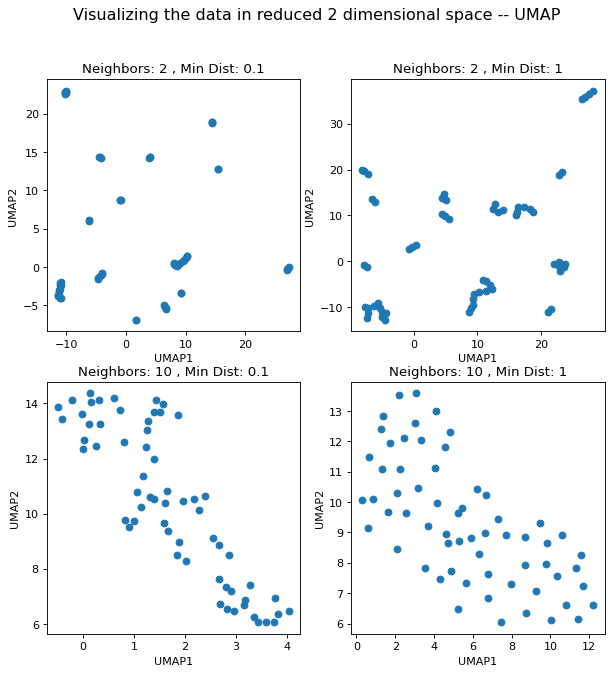

In [42]:
neighbors = [2, 10]
dists = [0.1, 1]

fig, axes = plt.subplots(2, 2, figsize=(9, 9), dpi=80)
fig.suptitle("Visualizing the data in reduced 2 dimensional space -- UMAP", size='x-large')

for i, n_neighbors in enumerate(neighbors):
    for j, min_dist in enumerate(dists):
        reducer =  UMAP(n_components=2, random_state=None, n_neighbors=n_neighbors, min_dist=min_dist)
        X_umap = reducer.fit_transform(X_scaled) 

        ax = axes[i, j]

        # plot
        ax.scatter(X_umap[:, 0], X_umap[:, 1])
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.set_title("Neighbors: " + str(n_neighbors) + " , Min Dist: " + str(min_dist))

## 2c. PCA


Variance explained by the first two principal components: 0.55


Text(0.5, 1.0, 'Visualizing the data in reduced 2 dimensional space')

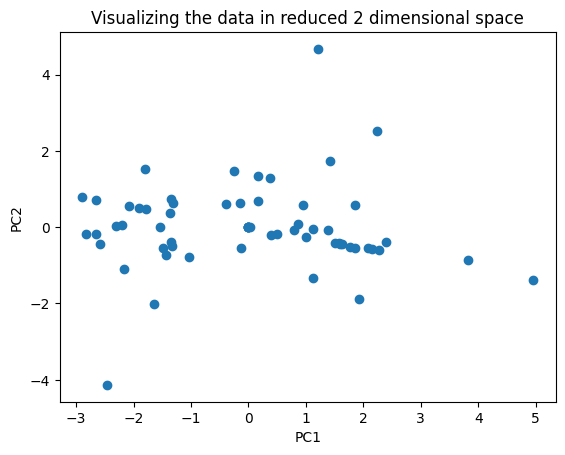

In [ ]:
# perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"\nVariance explained by the first two principal components: {pca.explained_variance_ratio_.sum():.2f}")

# plot
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualizing the data in reduced 2 dimensional space")

## 2d. Analysis of Different Parameters
t-SNE:
Lower perplexity leads to more, smaller groups. This implies that lower lower perplexity can help emphasize local relationships. On the flip size, higher perplexity can help highlight bonds across the population. 

UMAP:
The neighbors parameter is again similar to perplexity in t-SNE. A lower value emphasize local relationships. This can be seen by the small clusters when neighbers is 2 vs when it is 10. 

min_dist parameter seems to control the spread of the points or how tightly they are packed together. The lower the number, the tighter the spread. 

# 3. Clustering
## 3a. K-Means

### i. Extract Inertia/Distances and Plot Elbow

In [49]:
# Function to compute inertia (within-cluster sum of squares)
def compute_inertia(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(data)
    return kmeans.inertia_

# Pre-calculate the distances for the Elbow Method
def find_elbow(x, y):
    # Normalize the x and y values
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))

    # Line connecting the first and last points
    x_line = np.array([x_norm[0], x_norm[-1]])
    y_line = np.array([y_norm[0], y_norm[-1]])

    distances = []
    for i in range(len(x)):
        point = np.array([x_norm[i], y_norm[i]])
        dist = np.abs(np.cross(x_line - y_line, point - y_line)) / np.linalg.norm(x_line - y_line)
        distances.append(dist)

    # Find the index of the maximum distance
    elbow_index = np.argmax(distances)
    return distances

# Assume k_range and inertias are precomputed
k_range = np.array(range(1, 11))
print('Calculating inertias')
inertias = np.array([compute_inertia(k, X_scaled) for k in k_range])  # Replace with your precomputed inertia values
print('Calculating distances')
distances = find_elbow(k_range, inertias)

# Define the plotting function with a slider
def plot_elbow(k):
    fig, ax1 = plt.subplots(figsize=(8, 6))
    plt.suptitle('Finding the Optimal Number of Clusters Using Elbow')

    # Primary y-axis: Inertia
    ax1.plot(k_range, inertias, 'bo-', label='Inertia')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')

    # Secondary y-axis: Distances
    ax2 = ax1.twinx()
    ax2.plot(k_range, distances, 'go--', label='Distance', alpha=0.5)
    ax2.set_ylabel('Distance')

    # Add a vertical line and display the current distance
    ax1.axvline(x=k, color='r', linestyle='--', label='Selected k')
    ax2.plot(k, distances[k-1], 'ro')  # Plot the point on the distance curve
    ax2.text(k, distances[k-1], f'{distances[k-1]:.4f}', fontsize=10, ha='left', va='bottom')

    ax1.set_title(f'Elbow Method: k={k}, Inertia={inertias[k-1]:.2f}, Distance={distances[k-1]:.4f}')

    fig.legend(loc='upper right')
    plt.show()

# Create an interactive slider
interact(plot_elbow, k=(1, 10, 1))
plt.show()

Calculating inertias
Calculating distances


interactive(children=(IntSlider(value=5, description='k', max=10, min=1), Output()), _dom_classes=('widget-int…

### ii. Perform K-Means with Optimal K

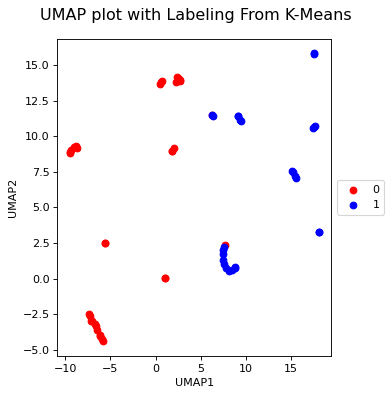

In [118]:
best_k = np.argmax(distances) + 1

# Run K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=None) # <=== Complete code
clusters = kmeans.fit_predict(X_scaled) # <=== Complete code

cdict = {-1: 'pink', 0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'black', 5: 'purple'}

fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=80)
fig.suptitle("UMAP plot with Labeling From K-Means", size='x-large')

for g in np.unique(clusters):
    idx = np.where(clusters == g)
    ax.scatter(X_umap[idx, 0], X_umap[idx, 1], c=cdict[g], label=g)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()


In [ ]:
# create new dataframe with kmeans labels and save to csv

dataK = data.assign(kmeans_labeles = clusters)
dataK.to_csv('electrophysiology_data_kmeans.csv', index=True)

## 3b. Agglomerative Clustering

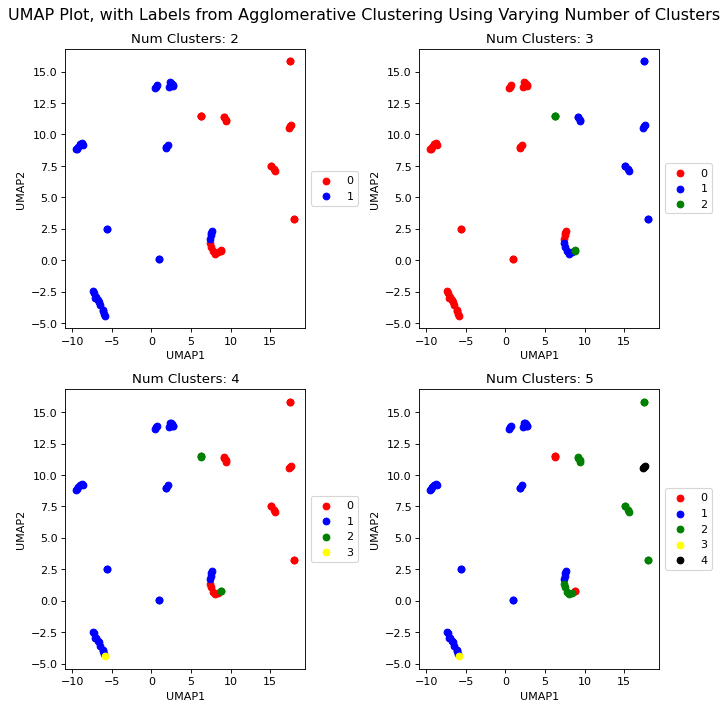

In [119]:
numClusters = [2, 3, 4, 5]

fig, axes = plt.subplots(2, 2, figsize=(9, 9), dpi=80)
fig.suptitle("UMAP Plot, with Labels from Agglomerative Clustering Using Varying Number of Clusters", size='x-large')

cdict = {-1: 'pink', 0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'black', 5: 'purple'}

for i, n_clusters in enumerate(numClusters):
    # Apply Hierarchical Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    clusters_agg = agg_clustering.fit_predict(X_scaled)

    ax = axes[i//2, i%2]

    # plot
    for g in np.unique(clusters_agg):
        idx = np.where(clusters_agg == g)
        ax.scatter(X_umap[idx, 0], X_umap[idx, 1], c=cdict[g], label=g)
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_title("Num Clusters: " + str(n_clusters))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

# 3c. DBSCAN

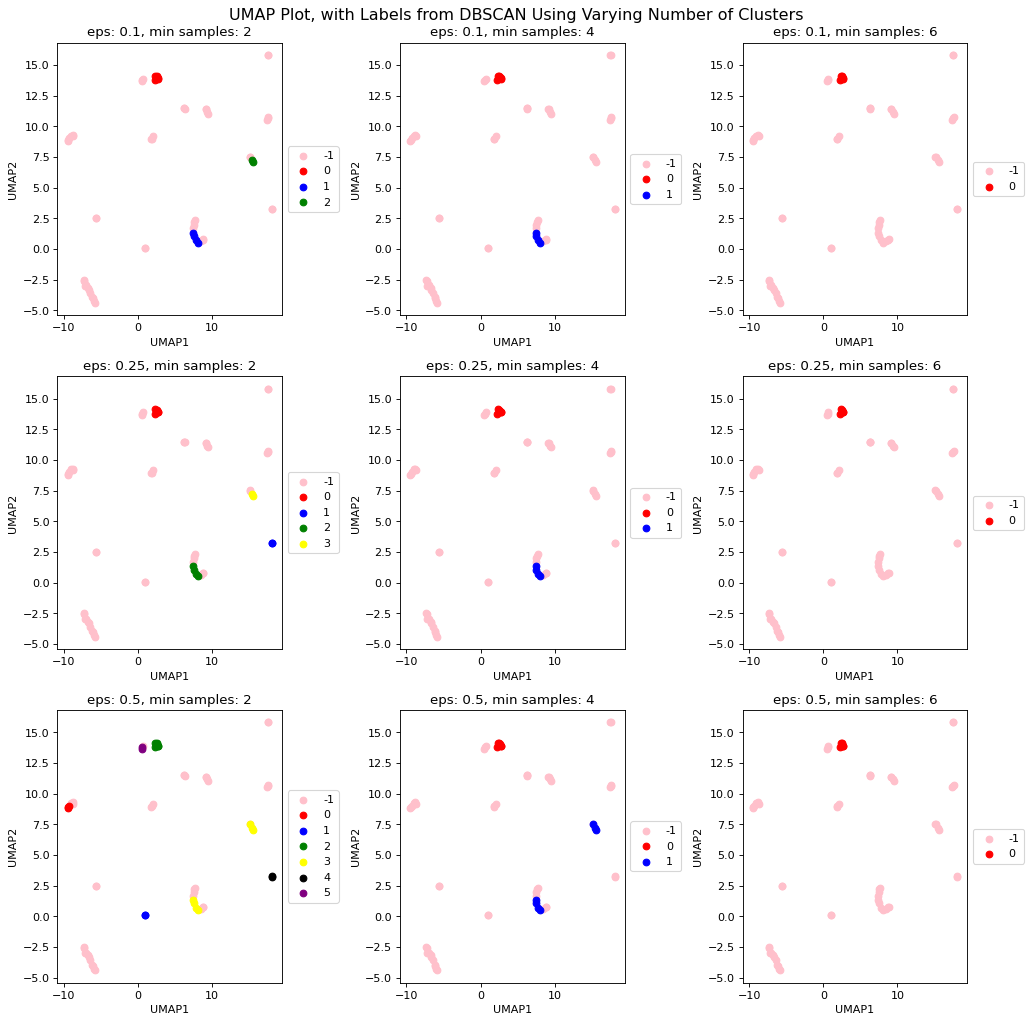

In [ ]:
epsValues = [.1, .25, .5]
msValues = [2, 4, 6]

fig, axes = plt.subplots(4, 3, figsize=(13, 13), dpi=80)
fig.suptitle("UMAP Plot, with Labels from DBSCAN Using Varying Number of Clusters", size='x-large')

cdict = {-1: 'pink', 0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'black', 5: 'purple'}

for i, eps in enumerate(epsValues):
    for j, min_samples in enumerate(msValues):
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', p=2)
        clusters_dbscan = dbscan.fit_predict(X_scaled)

        ax = axes[i, j]

        # plot
        for g in np.unique(clusters_dbscan):
            idx = np.where(clusters_dbscan == g)
            ax.scatter(X_umap[idx, 0], X_umap[idx, 1], c=cdict[g], label=g)
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.set_title("eps: " + str(eps) + ", min samples: " + str(min_samples))
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()